# XGBoost

In [1]:
import optuna
from xgboost import XGBClassifier
from utils.preprocessing import *
from utils.visualization import *
from utils.trainer import *
from utils.helpers import *
from utils.config import *

In [2]:
model_name       = 'xgboost'
best_params_path = paths[model_name]['best_params']
model_path_list  = paths[model_name]['models']
pred_5folds_path = paths[model_name]['pred_5folds']
shap_fi_path     = paths[model_name]['shap_fi']
fi_path          = paths[model_name]['feature_importance']

## 1. Load data

In [3]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in X_train_paths]
y_train_list = [pd.read_csv(path) for path in y_train_paths]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in X_val_paths]
y_val_list   = [pd.read_csv(path) for path in y_val_paths]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

## 2. Hyperparameters Tuning

In [4]:
def objective(trial):    
    param = {
        'verbosity'       : 0,
        'objective'       : 'binary:logistic',
        'eval_metric'     : 'logloss',
        'booster'         : 'gbtree',
        'grow_policy'     : 'depthwise',
        'lambda'          : trial.suggest_float('lambda', 1e-8, 1.0),
        'subsample'       : trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'max_depth'       : trial.suggest_int('max_depth', 1, 3),
        'alpha'           : trial.suggest_float('alpha', 1e-8, 0.5),
        'eta'             : trial.suggest_float('eta', 1e-8, 1.0),
        'gamma'           : trial.suggest_float('gamma', 1e-8, 1.0),
    }
    
    trainer = BaseTrainer(model=XGBClassifier(**param))
    mean_metrics, *_ = trainer.perform_cross_validation(
        X_train_list, y_train_list,
        X_val_list, y_val_list,
        verbose=0
    )
    avg = (mean_metrics.get('mean_accuracy') + mean_metrics.get('mean_f1_score') + mean_metrics.get('mean_roc_auc')) / 3
    return avg

In [5]:
HP_TUNING=False

if HP_TUNING:
    direction = 'maximize'
    n_trials  = 500
    n_jobs    = -1

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    best_params = study.best_trial.params
    best_params.update({
        'verbosity'  : 0,
        'objective'  : 'binary:logistic',
        'eval_metric': 'logloss',
        'booster'    : 'gbtree',
        'grow_policy': 'depthwise',
    })
else:
    best_params = load_json(best_params_path)
    
best_params

{'lambda': 0.9659961779841149,
 'subsample': 0.9793887594776909,
 'colsample_bytree': 0.8923767054548004,
 'max_depth': 2,
 'alpha': 0.117627077086931,
 'eta': 0.42605553729825163,
 'gamma': 0.48427553570158555,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'booster': 'gbtree',
 'grow_policy': 'depthwise'}

## 3. Train with 5-fold cross validation

In [6]:
trainer = BaseTrainer(model=XGBClassifier(**best_params))
mean_metrics, y_pred_list, y_pred_proba_list, fi_list = trainer.perform_cross_validation(
    X_train_list, y_train_list,
    X_val_list, y_val_list,
    verbose=1,
    # model_path_list=model_path_list, # uncomment if you want to save newly trained models
)

Fold 1/5:


	- ACCURACY: 0.7818
	- ROC_AUC: 0.8747
	- F1_SCORE: 0.7391
	- MSE: 0.1584
	- PRECISION: 0.8095
	- RECALL: 0.6800
	- SPECIFICITY: 0.8667

Fold 2/5:
	- ACCURACY: 0.9091
	- ROC_AUC: 0.9507
	- F1_SCORE: 0.9020
	- MSE: 0.0868
	- PRECISION: 0.8846
	- RECALL: 0.9200
	- SPECIFICITY: 0.9000

Fold 3/5:
	- ACCURACY: 0.9455
	- ROC_AUC: 0.9587
	- F1_SCORE: 0.9388
	- MSE: 0.0780
	- PRECISION: 0.9583
	- RECALL: 0.9200
	- SPECIFICITY: 0.9667

Fold 4/5:
	- ACCURACY: 0.8333
	- ROC_AUC: 0.8814
	- F1_SCORE: 0.8302
	- MSE: 0.1363
	- PRECISION: 0.7857
	- RECALL: 0.8800
	- SPECIFICITY: 0.7931

Fold 5/5:
	- ACCURACY: 0.8519
	- ROC_AUC: 0.9448
	- F1_SCORE: 0.8400
	- MSE: 0.1011
	- PRECISION: 0.8400
	- RECALL: 0.8400
	- SPECIFICITY: 0.8621

------------------------------
	- MEAN_ACCURACY: 0.8643
	- MEAN_ROC_AUC: 0.9220
	- MEAN_F1_SCORE: 0.8500
	- MEAN_MSE: 0.1121
	- MEAN_PRECISION: 0.8556
	- MEAN_RECALL: 0.8480
	- MEAN_SPECIFICITY: 0.8777


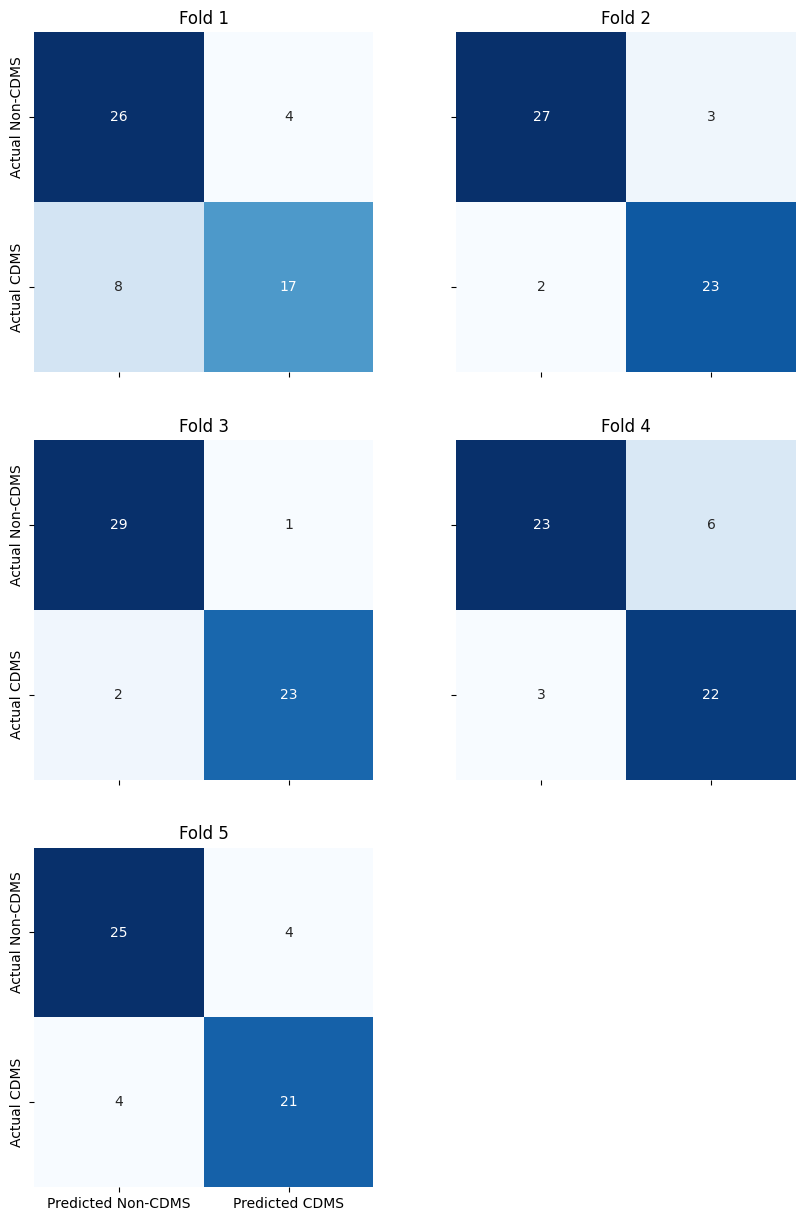

In [7]:
plot_confusion_matrix_folds(
    y_test_list=y_val_list,
    y_pred_list=y_pred_list,
)

## 4. Feature Importance

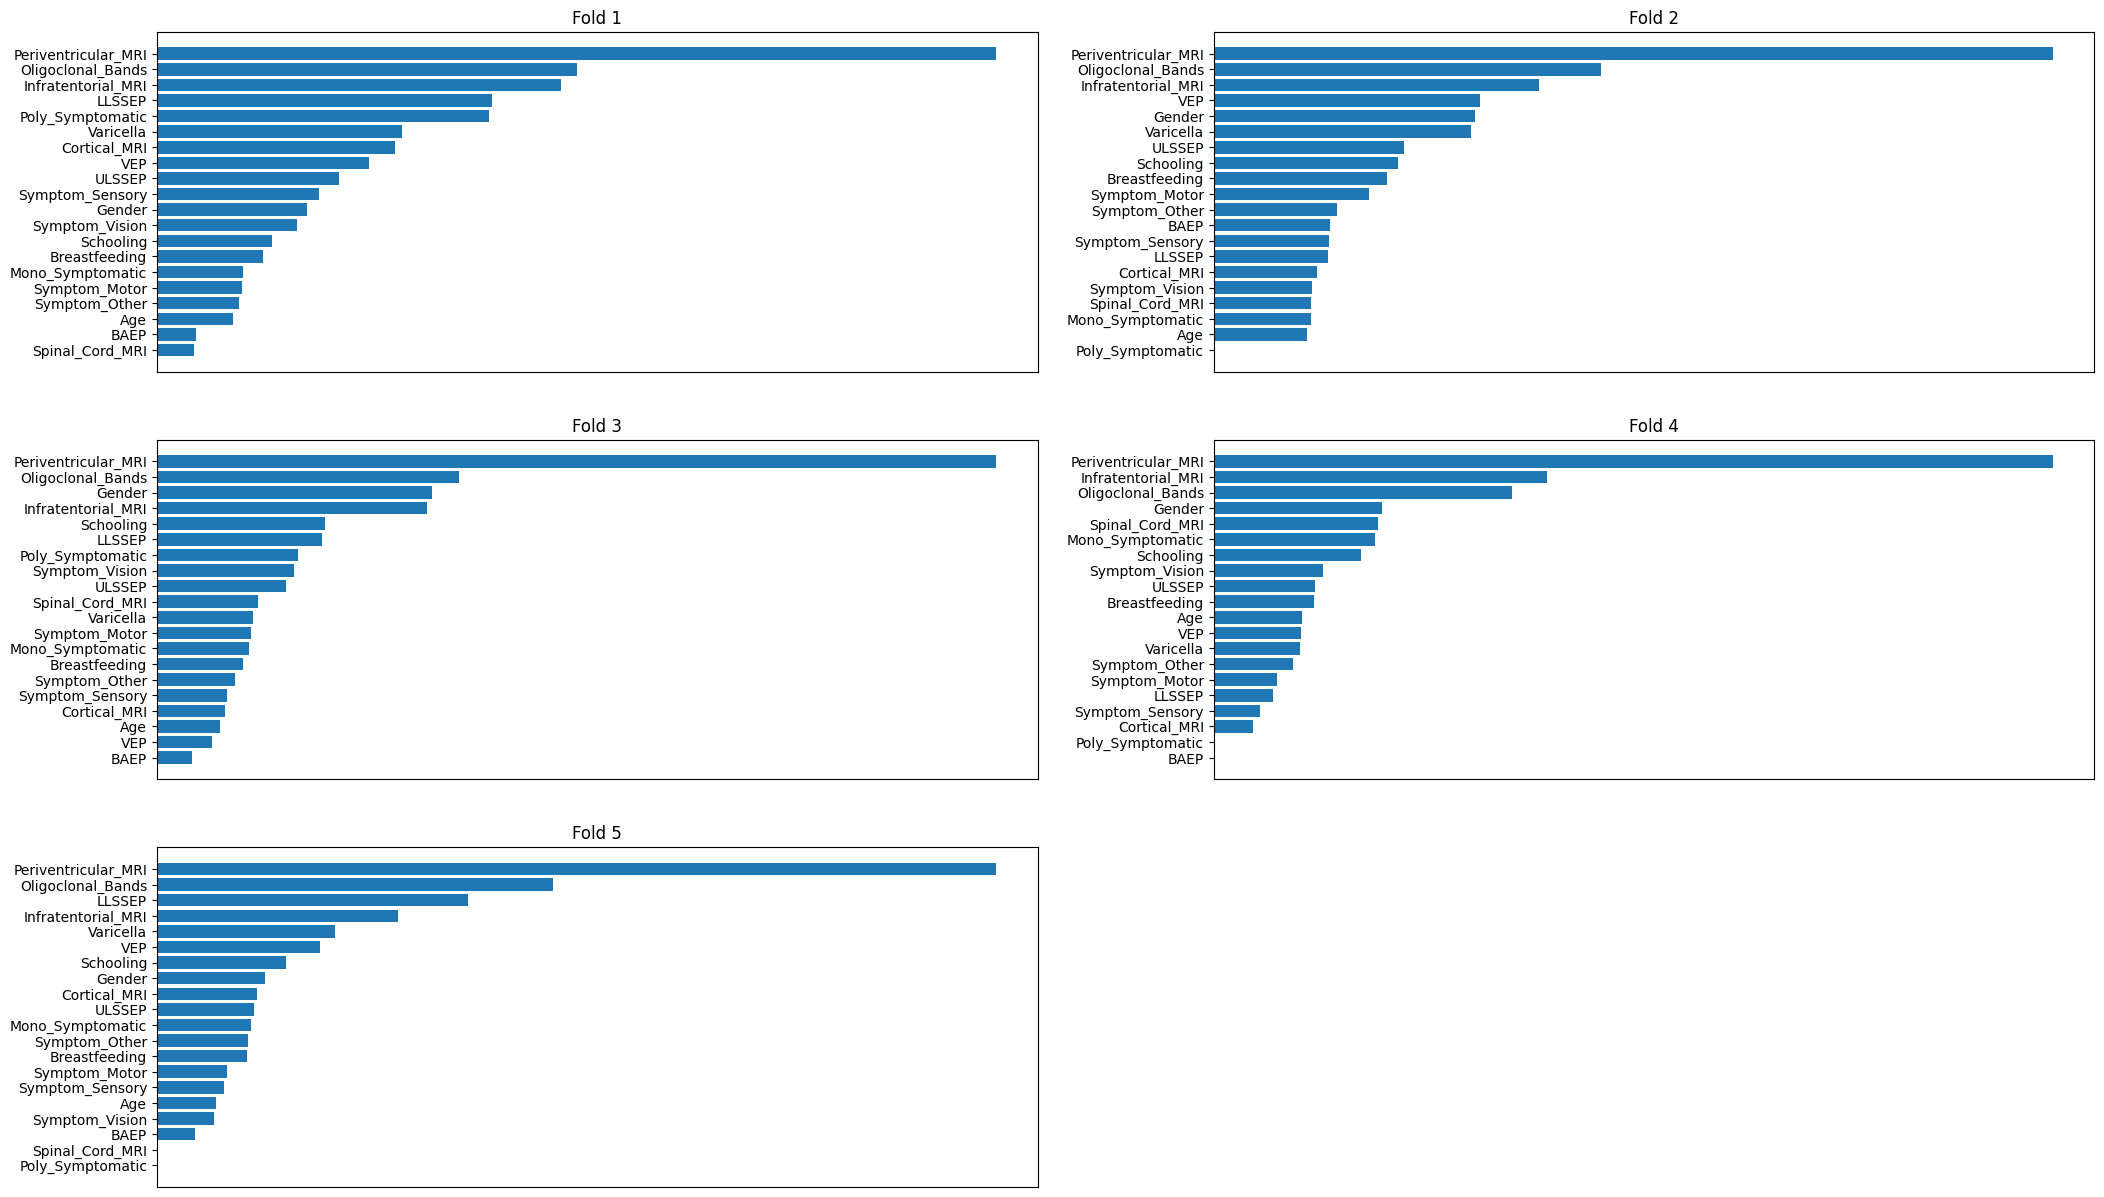

In [8]:
plot_catboost_feature_importance_folds(
    fi_list=fi_list,
    columns_folds=[X_train.columns for X_train in X_train_list]
)

In [9]:
fi_dfs = []
for fi, X_train_fold in zip(fi_list, X_train_list):
    fi_df = pd.DataFrame({'Feature Id': X_train_fold.columns, 'Importances': fi})
    fi_dfs.append(fi_df)

feature_importance = average_feature_importances(fi_dfs)
# feature_importance.to_csv(fi_path, index=False)
feature_importance

,Feature Id,Importances
0,Periventricular_MRI,0.242616
1,Oligoclonal_Bands,0.102895
2,Infratentorial_MRI,0.089549
3,LLSSEP,0.055315
4,Gender,0.055183
5,Varicella,0.047419
6,Schooling,0.043078
7,VEP,0.042842
8,ULSSEP,0.038907
9,Breastfeeding,0.031440


## 5. Get predictions

In [10]:
analyzed_dfs = []

for fold in range(1, 6):
    # Load data for the current fold
    X_train, y_train, X_val, y_val = load_data_fold(fold)

    # Load trained model for the current fold
    model = load_model_fold(fold, model_name=model_name)

    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,-1]

    # Add ground truths and predictions to the current df
    analyzed_df = X_val.copy()
    analyzed_df['Actual'] = y_val
    analyzed_df['Predicted'] = y_pred
    analyzed_df['Predicted_Proba'] = y_pred_proba
    analyzed_dfs.append(analyzed_df)

analyzed_df_aggregated = pd.concat(analyzed_dfs, axis=0).reset_index(drop=True)
print(f'analyzed_df_aggregated.shape: {analyzed_df_aggregated.shape}')

# analyzed_df_aggregated.to_csv(pred_5folds_path, index=False)
# print(f'Save df to {pred_5folds_path}')

analyzed_df_aggregated.shape: (273, 23)


## 6. Explain with SHAP

In [11]:
import shap

models = [load_model_fold(fold+1, model_name) for fold in range(5)]
shap_values_folds = []

for fold in range(5):
    model = models[fold]
    X_val = X_val_list[fold]

    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(X_val)
    mean_sv = np.mean(np.abs(sv), axis=0)
    shap_values_folds.append(mean_sv)

# Aggregate SHAP values across folds
aggregated_shap_values = np.mean(shap_values_folds, axis=0)

# Calculate mean absolute SHAP values for feature importance
feature_names = X_val_list[0].columns.to_list()
shap_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': aggregated_shap_values
})

# Sort by importance
#shap_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
shap_feature_importance.to_csv(shap_fi_path, index=False)
shap_feature_importance

,Feature,Importance
0,Gender,0.337507
1,Age,0.424008
2,Schooling,0.626459
3,Breastfeeding,0.277690
4,Varicella,0.258630
5,Oligoclonal_Bands,0.547609
6,LLSSEP,0.148970
7,ULSSEP,0.141246
8,VEP,0.208488
9,BAEP,0.038899
